## Instructions

Which Novel Do I Belong To?

In this task, you are expected to train a Machine Learning model that classifies a given line as belonging to one of the following 12 novels:

0: alice_in_wonderland <br>
1: dracula <br>
2: dubliners <br>
3: great_expectations <br>
4: hard_times <br>
5: huckleberry_finn <br>
6: les_miserable <br>
7: moby_dick <br>
8: oliver_twist <br>
9: peter_pan <br>
10: tale_of_two_cities <br>
11: tom_sawyer <br>


Description:

You are provided with a zip file (offline_challenge.zip) containing three text files - xtrain.txt, ytrain.txt, xtest.txt. Each line in xtrain.txt and xtest.txt comes from a different novel. The data has been obfuscated, however the patterns in them are preserved. The novel ids corresponding to xtrain.txt are specified in ytrain.txt. You can use these labels to train a Machine Learning model (Deep Learning preferred).

With the learned model, predict the novel ids of the lines in xtest.txt (one prediction per line). As part of your submission, include

a) your predictions in a file named ytest.txt (in the same format as ytrain.txt) <br>
b) Expected accuracy on the test set <br>
c) the source code for training and prediction (< 10MB) <br>
d) a brief description of your method (optional) <br>




# Introduction

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from collections import defaultdict
from pathlib import Path

import fasttext
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Embedding, Flatten, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import utils as utils

/home/julianhatwell/anaconda3/envs/pytonu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/julianhatwell/anaconda3/envs/pytonu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/julianhatwell/anaconda3/envs/pytonu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/julianhatwell/anaco

In [3]:
plt.rcParams['figure.figsize'] = 10, 10
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Independent of the outcome, I want to say thank you for the challenge. It is a plain machine learning task, where I don't have to deal with hour long feature engineering or the exploration of unknown data formats/ python frameworks. And the task looks like fun. 😊

First, let's have a look at data. 

So, let's have a look at the authors first:

0: alice_in_wonderland - Lewis Carroll - 1865 <br>
1: dracula  - Bram Stoker - 1897 <br>
2: dubliners - James Joyce - 1914 <br>
3: great_expectations - Charles Dickens - 1861 <br>
4: hard_times - Charles Dickens - 1854 <br>
5: huckleberry_finn - Mark Twain - 1884 <br>
6: les_miserable - Victor Hugo - 1862 <br>
7: moby_dick - Herman Melville - 1851<br>
8: oliver_twist - Charles Dickens - 1836 <br>
9: peter_pan - J. M. Barrie - 1904 <br>
10: tale_of_two_cities - Charles Dickens - 1859 <br>
11: tom_sawyer - Mark Twain - 1876 <br>

There are multiple novels written by the same author. So I would expect, that there will be some classification errors between 5 and 11 (Mark Twain) and between 3, 4, 8 and 10 (Charles Dickens). The personal writing style of an author shouldn't change too much.
In general most of the novels, where written in the middle of the 19th century (except 2, which is part of the modernity). So I would expect a similar vocabulary. 

In [4]:
folder_path = Path("./data/offline_challenge/")
training_file = "xtrain_obfuscated.txt"
label_file = "ytrain.txt"
test_file = "xtest_obfuscated.txt"
results_file = "ytest.txt"

seed = 12345
train_val_split = 0.8

In [5]:
label_list = ["alice_in_wonderland",
              "dracula",
              "dubliners",
              "great_expectations",
              "hard_times",
              "huckleberry_finn",
              "les_miserable",
              "moby_dick",
              "oliver_twist",
              "peter_pan",
              "tale_of_two_cities",
              "tom_sawyer"]

In [6]:
training_data = utils.load_text(Path(folder_path, training_file))
test_data = utils.load_text(Path(folder_path, test_file))

labels = utils.load_text(Path(folder_path, label_file))

"Call me Ishmael." is how Moby Dick starts, but in our example it's "satwamuluhqgu". The text is obfuscated and there are no whitespaces or other punctuations. In total there are 26 different characters in the training data, which are all lower case (checked, but not shown here). So, here it makes sense to classify the data by character sequence or character n-grams. 

In [7]:
print(labels[0])
print(training_data[0])

7
satwamuluhqgulamlrmvezuhqvkrpmletwulcitwskuhlemvtwamuluhiwiwenuhlrvimvqvkruhulenamuluhqgqvtwvimviwuhtwamuluhulqvkrenamcitwuhvipmpmqvuhskiwkrpmdfuhlrvimvskvikrpmqvuhskmvgzenleuhqvmvamuluhulenamuluhqvletwtwvipmpmgzleenamuhtwamuluhtwletwdfuhiwkrxeleentwxeuhpmqvuhtwiwmvamdfuhpkeztwamuluhvimvuhqvtwmkpmpmlelruhgztwtwskuhtwlrkrpmlruhpmuluhqvenuhtwyplepmxeuhenuhamypkrqvuhamulmvdfuhqvskentwamletwlrlrpmiwuhtwamul


## Baseline

As you see the labels are not evenly distributed. There are much more samples of Moby Dick than e.g. of Alice in wonderland. This is important for a stratified train/test split. I take a split of 80/20 for the training and validation set. I already have a test set, but the evaluation is not in my hands. <br>
Also a better approach for hyperparameter search is in general cross-validation, but based on time and scope of this task, I prefer just to mention it. 

In [8]:
label_counter = utils.counter(labels)
sorted(label_counter.items(), key=lambda item: item[1], reverse=True)

[('7', 5097),
 ('6', 4226),
 ('3', 4023),
 ('8', 3634),
 ('1', 3459),
 ('10', 3052),
 ('4', 2337),
 ('5', 2283),
 ('2', 1471),
 ('11', 1408),
 ('9', 980),
 ('0', 543)]

In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    np.array(training_data),  
    np.array(labels), 
    test_size=1-train_val_split, 
    train_size=train_val_split, 
    random_state=seed, 
    shuffle=True, 
    stratify=np.array(labels)
)

Short check, if the labels are correctly stratified.

In [10]:
# counter_y_train = utils.counter(y_train)
counter_y_val = utils.counter(y_val)

for k in counter_y_val.keys():
    print(f"{counter_y_val[k]/label_counter[k]:.3f}")

0.200
0.200
0.200
0.200
0.200
0.200
0.200
0.200
0.200
0.200
0.200
0.201


As a simple baseline I want to use the fasttext library (https://fasttext.cc/) from facebook and developed from Tomas Mikolov (word2vec creator). In practice, I use it as a standard tool for simple nlp tasks (for me, mostly the creation of language specific word embeddings). I don't have much experience with text classification. It is quite powerful, very fast and very simple to use. The main idea is to use character n-grams, which fits perfectly to our training data.

Basically, it is a linear model with a softmax layer to compute the probabilities of each predefined class. The model is trained via stochastic gradient descent and learning rate decay.

Paper: <br>
    - classification: https://arxiv.org/pdf/1607.01759.pdf <br>
    - word representations: https://arxiv.org/pdf/1607.04606.pdf <br>

In [11]:
baseline_train_name = Path(folder_path, "baseline_train.txt")
baseline_val_name = Path(folder_path, "baseline_val.txt")

utils.write_fasttext_text(Path(baseline_train_name), X_train, y_train)
utils.write_fasttext_text(Path(baseline_val_name), X_val, y_val)

Also this library comes with an automated hyperparameter optimization. So I don't need to use GridSearch or other methods. Since it is a simple baseline, let's see, if I give it 5 minutes for optimizing the F1-Score. 

In [18]:
model = fasttext.train_supervised(input=str(baseline_train_name),
                                  autotuneValidationFile=str(baseline_val_name),
                                  autotuneDuration=300)

One disadvantage of the fasttext model is, that it is very big. They implemented a method to reduce the size, but also the precision and recall will drop a bit. And in general, this reduction takes too much time, so I go for the 1,4 GB file.

In [19]:
# model.quantize()

In [20]:
model.save_model("fasttext_homework.bin")


So, the model has a precision and recall of around 83,4 % for the top1 prediction. This is pretty good for an out of the pocket solution with zero work. 

In [22]:
print(model.test(str(baseline_val_name)))

(6503, 0.8357681070275258, 0.8357681070275258)


In [23]:
y_hat = []
y_prob = []

for text in X_val:
    result = model.predict(text)
    
    y_hat.append(int(result[0][0].replace("__label__", "")))
    y_prob.append(result[1][0])

In [24]:
y_val = [int(i) for i in y_val]

The overall F1-Score is at 0.83. The model has some problems with Charles Dickens' - Tale of two cities and Mark Twain's - Tom Sawyer. For Tom Sawyer, I would guess, we could achieve a better solution with more data. Strangely there is no overlap with Huckleberry Finn from the same author. E.g. Alice in Wonderland has less data, but a higher F1-Score. But also the story is quite unique for this book. 
With Tale of two cities are many misclassifications with Great Expectations and vice versa, also from Charles Dickens. I haven't read any of those both books, so I can't say, how similar they are. But since the model mixes up the prediction between both books, I assume they are quite similiar.

In [28]:
print(classification_report(y_val, y_hat, target_names=label_list))

                     precision    recall  f1-score   support

alice_in_wonderland       0.90      0.78      0.84       109
            dracula       0.82      0.85      0.84       692
          dubliners       0.81      0.79      0.80       294
 great_expectations       0.80      0.80      0.80       805
         hard_times       0.88      0.85      0.86       467
   huckleberry_finn       0.94      0.92      0.93       457
      les_miserable       0.83      0.88      0.86       845
          moby_dick       0.86      0.90      0.88      1019
       oliver_twist       0.87      0.86      0.86       727
          peter_pan       0.80      0.69      0.75       196
 tale_of_two_cities       0.75      0.70      0.72       610
         tom_sawyer       0.77      0.75      0.76       282

           accuracy                           0.84      6503
          macro avg       0.84      0.81      0.82      6503
       weighted avg       0.84      0.84      0.83      6503



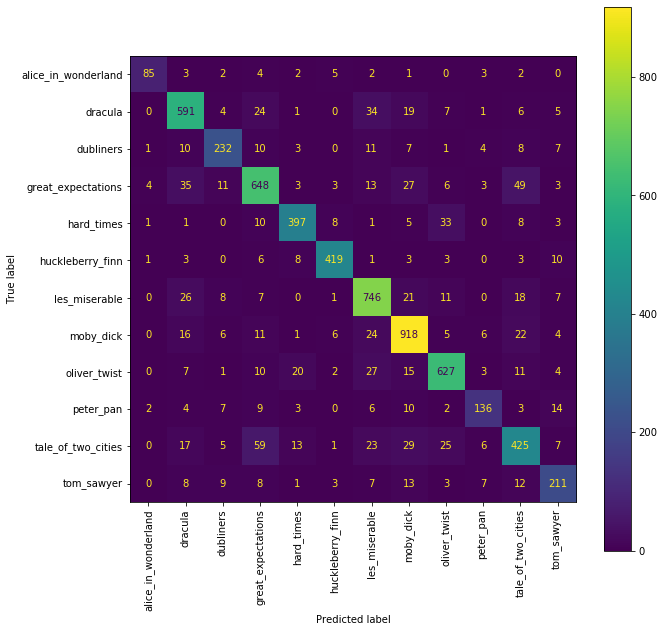

In [29]:
cm = confusion_matrix(y_val, y_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_list)

disp.plot(xticks_rotation="vertical") 

The hyperparameters are look except as the model dimension and the learning rate as sane. The learning rate is with 5 very high. I would have never choosen this parameter, since I wouldn't expect thath the training loss would converge during training. Also the model dimension of 540 parameters/nodes seems a bit big to me. Also the model splits the words in character n-grams from 3 to 6 characters.  

But in the end, the results matters and I'm confident with an F1-Score of 0.83.

In [30]:
print(f"Number of epochs {model.epoch}")
print(f"Initial learning rate {model.lr}")
print(f"Model dimension {model.dim}")
print(f"Size of the context window {model.ws}")
print(f"Number of negatice sampled {model.neg}")
print(f"Loss function {model.loss}")
print("\n")
print(f"Minimal number of word occurances {model.minCount}")
print(f"Minimal number of character ngram {model.minn}")
print(f"Maximal number of character ngram {model.maxn}")
print(f"Maximal length of word ngram {model.wordNgrams}")
print("\n")
print(f"Number of trained words {len(model.words)}")

Number of epochs 100
Initial learning rate 0.10522187477439467
Model dimension 64
Size of the context window 5
Number of negatice sampled 5
Loss function loss_name.softmax


Minimal number of word occurances 1
Minimal number of character ngram 3
Maximal number of character ngram 6
Maximal length of word ngram 1


Number of trained words 26011


## DeepLearning Model

So, the current approach seems good, but it feels a bit like a script kiddie approach. As a next step, the use of an LSTM would be logical. LSTMs uses the text as a sequence of words/characters and capture the character dependencies in this task. Since I have already a good enough baseline, I want to learn something new and train a character CNN, e.g. the one, which is mentioned in the fasttext paper. 


paper:
- https://arxiv.org/pdf/1509.01626.pdf

In general I work with pytorch, but debugging took really too much time (I wanted to have a dataloader + pytorch lightning), I switched back to keras.

Since the total length of each sentence isn't that high, I can use more filters and a slightly reduced pooling size.

In [31]:
n_filters = 512
hidden_layer = 1024
pool_size = 2
dropout = 0.5
learning_rate = 0.001
batch_size=128
epochs=100
loss = "categorical_crossentropy"

n_characters = 26
n_classes = len(set(labels))

Check if the training_data is still there

In [32]:
training_data[0]

'satwamuluhqgulamlrmvezuhqvkrpmletwulcitwskuhlemvtwamuluhiwiwenuhlrvimvqvkruhulenamuluhqgqvtwvimviwuhtwamuluhulqvkrenamcitwuhvipmpmqvuhskiwkrpmdfuhlrvimvskvikrpmqvuhskmvgzenleuhqvmvamuluhulenamuluhqvletwtwvipmpmgzleenamuhtwamuluhtwletwdfuhiwkrxeleentwxeuhpmqvuhtwiwmvamdfuhpkeztwamuluhvimvuhqvtwmkpmpmlelruhgztwtwskuhtwlrkrpmlruhpmuluhqvenuhtwyplepmxeuhenuhamypkrqvuhamulmvdfuhqvskentwamletwlrlrpmiwuhtwamul'

In this approach, I need to do a bit of preprocessing. 
I convert the characters of the training data to int. Also I make sure, that every training sample has the same length by adding zeros to the end.

For the labels, I use one-hot-encoding.

In [33]:
training_int_data = [utils.convert_char_to_int(i) for i in training_data]
training_int_labels = [int(i) for i in labels]

max_len = max(len(i) for i in training_int_data)

training_int_data = pad_sequences(training_int_data, maxlen=max_len, padding='post')
training_int_data = np.array(training_int_data, dtype='float32')

training_classes = to_categorical(training_int_labels)

In [34]:
embedding_weights = []
embedding_weights.append(np.zeros(n_characters))

for i in range(n_characters):
    
    one_hot_encoded_char = np.zeros(n_characters)
    one_hot_encoded_char[i] = 1
    embedding_weights.append(one_hot_encoded_char)
    
embedding_weights = np.array(embedding_weights)

Following the paper, I use 6 Conv1D-layers with max pooling for dimension reduction. Also I use three fully connected layers with dropout layers. All layers use ReLu as activation function, except a softmax for the last layer. 

AS an optimizer I pick Adam, since this algorithm converges comparable fast. 

In [35]:
model = Sequential()

model.add(
    Embedding(
        n_characters + 1, n_characters, input_length=max_len, weights=[embedding_weights]
    )
)

model.add(Conv1D(n_filters, 7, activation="relu"))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(Conv1D(n_filters, 7, activation="relu"))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(Conv1D(n_filters, 3, activation="relu"))
model.add(Conv1D(n_filters, 3, activation="relu"))
model.add(Conv1D(n_filters, 3, activation="relu"))
model.add(Conv1D(n_filters, 3, activation="relu"))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(Flatten())

model.add(Dense(hidden_layer, activation="relu",))
model.add(Dropout(dropout))
model.add(Dense(hidden_layer, activation="relu"))
model.add(Dropout(dropout))

model.add(Dense(n_classes, activation="softmax"))

model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss="categorical_crossentropy", 
    metrics=["accuracy"]
)

model.build(input_shape=training_int_data[0].shape)
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 452, 26)           702       
_________________________________________________________________
conv1d (Conv1D)              (None, 446, 512)          93696     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 223, 512)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 217, 512)          1835520   
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 108, 512)          0         
__________________

Again a stratified split with the same seed.

In [36]:
X_train, X_val, y_train, y_val = train_test_split(
    training_int_data,
    training_classes,
    test_size=1 - train_val_split,
    train_size=train_val_split,
    random_state=seed,
    shuffle=True,
    stratify=np.array(labels),
)

In [37]:
print(X_train.shape)
print(y_train.shape)

(26010, 452)
(26010, 12)


In [38]:
early_stopping = EarlyStopping(
    monitor="val_loss", verbose=1, patience=5, mode="min", restore_best_weights=True
)

model_checkpoint = ModelCheckpoint("sap_homework_epoch_{epoch}.h5")

In [39]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping, model_checkpoint],
)


Train on 26010 samples, validate on 6503 samples
Epoch 1/100
26010/26010 [==============================] - 520s 20ms/sample - loss: 2.2561 - acc: 0.1890 - val_loss: 2.0056 - val_acc: 0.2726
Epoch 2/100
26010/26010 [==============================] - 558s 21ms/sample - loss: 1.8373 - acc: 0.3398 - val_loss: 1.6145 - val_acc: 0.4304
Epoch 3/100
26010/26010 [==============================] - 552s 21ms/sample - loss: 1.4325 - acc: 0.4923 - val_loss: 1.3704 - val_acc: 0.5113
Epoch 4/100
26010/26010 [==============================] - 540s 21ms/sample - loss: 1.2481 - acc: 0.5636 - val_loss: 1.2263 - val_acc: 0.5745
Epoch 5/100
26010/26010 [==============================] - 564s 22ms/sample - loss: 1.0695 - acc: 0.6272 - val_loss: 1.1456 - val_acc: 0.6146
Epoch 6/100
26010/26010 [==============================] - 525s 20ms/sample - loss: 0.9391 - acc: 0.6722 - val_loss: 1.0116 - val_acc: 0.6559
Epoch 7/100
26010/26010 [==============================] - 521s 20ms/sample - loss: 0.8133 - acc: 0

In [40]:
def plot_metrics(history):
    metrics = ["loss", "accuracy"]
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(
            history.epoch, history.history[metric], color=colors[0], label="Train"
        )
        plt.plot(
            history.epoch,
            history.history["val_" + metric],
            color=colors[0],
            linestyle="--",
            label="Val",
        )
        plt.xlabel("Epoch")
        plt.ylabel(name)
        if metric == "loss":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "auc":
            plt.ylim([0.8, 1])
        else:
            plt.ylim([0, 1])

        plt.legend()


There is no reduction of the loss after epoch 8. So early stopping restores the weight of this epoch. 
The graph for the loss shows a nice example of overfitting after epoch 8.

KeyError: 'accuracy'

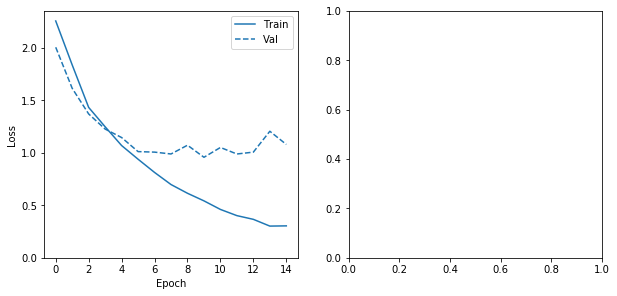

In [41]:
plot_metrics(history)

y_val and scores are one_hot_encoded, so I need to take the argmax to get the right label. 

In [42]:
scores = model.predict(X_val)
y_hat = np.argmax(scores,axis=1)

y_val = np.argmax(y_val,axis=1)

First, I'm impressed, how easy this was to implement and also, that it worked. Compared with our baseline model, this approach is weaker in every category. Probably with some hyperparameter tuning better results can be achieved. 

In [43]:
print(classification_report(y_val, y_hat, target_names=label_list))

                     precision    recall  f1-score   support

alice_in_wonderland       0.75      0.56      0.64       109
            dracula       0.69      0.70      0.69       692
          dubliners       0.38      0.33      0.35       294
 great_expectations       0.72      0.74      0.73       805
         hard_times       0.78      0.79      0.78       467
   huckleberry_finn       0.75      0.88      0.81       457
      les_miserable       0.78      0.74      0.76       845
          moby_dick       0.88      0.79      0.83      1019
       oliver_twist       0.94      0.71      0.81       727
          peter_pan       0.30      0.40      0.34       196
 tale_of_two_cities       0.46      0.68      0.55       610
         tom_sawyer       0.69      0.45      0.55       282

           accuracy                           0.70      6503
          macro avg       0.68      0.65      0.65      6503
       weighted avg       0.73      0.70      0.71      6503



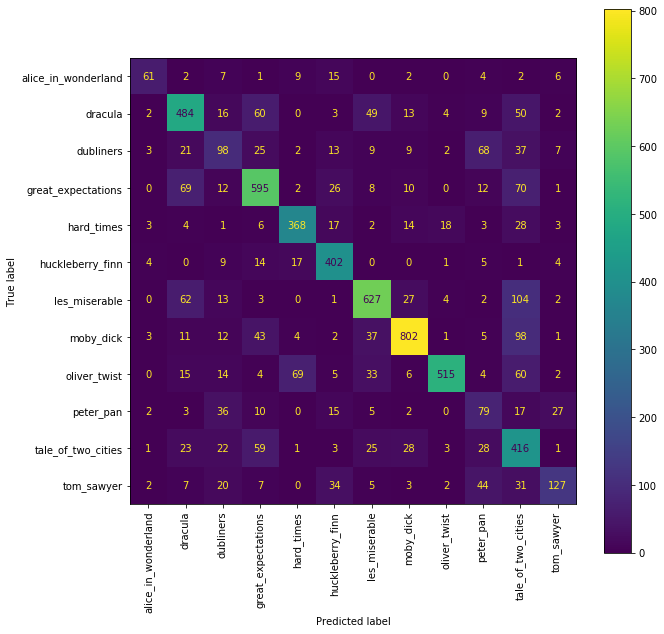

In [44]:
cm = confusion_matrix(y_val, y_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_list)

disp.plot(xticks_rotation="vertical") 

## Summary and Outlook

This is a bit embarrassing, but my baseline model is better than the char-CNN. So I will use the fasttext model for my test predictions.

## Test prediction

I got a F1-score of 0.83 on the validation dataset. Since I used the validation set also for hyperparameter search, I definitely introduced the model to some bias in the data. On the test set, I expect  drop of the overall F1-Score to around 0.78 - 0.80. 

In [46]:
# model = fasttext.load_model("baseline.bin")
model = fasttext.load_model("fasttext_homework.bin")

In [47]:
y_hat_test = []

for text in test_data:
    result = model.predict(text)
    y_hat_test.append(result[0][0].replace("__label__", ""))

In [48]:
assert len(test_data) == len(y_hat_test)

In [49]:
utils.save_text(Path(folder_path, results_file), y_hat_test)